# Solve 3D
Solving 2+1 dimensional system on cartesion (in time) mesh, sequentually for each time slab

## Define Functions

In [1]:
import sys
sys.path.append("..")
from ngsolve import *
SetHeapSize(100*1000*1000)

from trefftzngs import *
from DGeq import *
from prodmesh import *
import time
from netgen.geom2d import unit_square

In [2]:
def SolveWaveeq(fes,fullsys,mesh):
    sq = sqrt(0.5)
    truesol = sin( c*z+sq*(x+y) )
    v0 = c*cos(c*z+sq*(x+y))
    sig0 = CoefficientFunction(( -sq*cos(c*z+sq*(x+y)),-sq*cos(c*z+sq*(x+y)) ))
    gradtruesol = CoefficientFunction( (-sig0[0],-sig0[1], v0) )
    
    gfu = GridFunction(fes)
    gfu.Set(truesol) 
    gD = v0
    
    t = 0
    while t*t_stepsize<finaltime:
        t+=1
        gD = c*cos(c*(z+t*t_stepsize)+sq*(x+y))
        start = time.clock()
        [a,f] = DGeqsys(fes,gfu,0,0,c,gD,False,True)
        #print("DGsys: ", str(time.clock()-start))

        start = time.clock()
        [gfu, cond] = DGsolve(fes,a,f)
        #print("DGsolve: ", str(time.clock()-start))

        truesol = sin(c*(z+t*t_stepsize)+sq*(x+y))
        gradtruesol = CoefficientFunction( (sq*cos(c*(z+t*t_stepsize)+sq*(x+y)),sq*cos(c*(z+t*t_stepsize)+sq*(x+y)),c*cos(c*(z+t*t_stepsize)+sq*(x+y)) ) )
        L2error = sqrt(Integrate((truesol - gfu)*(truesol - gfu), mesh))
        sH1error = sqrt(Integrate((gradtruesol - grad(gfu))*(gradtruesol - grad(gfu)), mesh))
    
    print("timesteps: " + str(t))
    dof=fes.ndof/mesh.ne
    cond = 1
    return [dof,cond,L2error,sH1error]

## Run comparison

In [3]:
c = 2
order = 10
k = 1
basemeshsize = 1/4
t_stepsize_small = basemeshsize / c * 0.8
fak_t_stepsize_big = 5
t_stepsize_big = t_stepsize_small * fak_t_stepsize_big 
fak_t_stepsize_big = 5
n_t_stepsize_small = 10
finaltime = t_stepsize_small * n_t_stepsize_small
print("finaltime: " + str(finaltime) + " big step size: " + str(t_stepsize_big) + " small step size: " + str(t_stepsize_small) + " wave number: " + str(c) + " space mesh size: " + str(basemeshsize) + " ststep*c: " + str(t_stepsize_small * c))

ngmeshbase = unit_square.GenerateMesh(maxh = basemeshsize)
#mesh = ProdMesh(ngmeshbase,t_steps)

solution = []

for ordr in range(2,order):
    print("ORDER:" + str(ordr))
      
    t_stepsize = t_stepsize_big
    mesh = PeriodicProdMesh(ngmeshbase,t_stepsize)
    fes = FESpace("trefftzfespace", mesh, order = ordr, wavespeed = c, dgjumps=True)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, False, mesh)
    solution.append([t_stepsize,ordr,dof*n_t_stepsize_small/fak_t_stepsize_big,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))
    
    t_stepsize = t_stepsize_small
    mesh = PeriodicProdMesh(ngmeshbase,t_stepsize)
    fes = FESpace("trefftzfespace", mesh, order = ordr, wavespeed = c, dgjumps=True)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, False, mesh)
    solution.append([t_stepsize,ordr,dof*n_t_stepsize_small,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

finaltime: 1.0 big step size: 0.5 small step size: 0.1 wave number: 2 space mesh size: 0.25 ststep*c: 0.2
ORDER:2
timesteps: 2
btype: Trefftz dof: 9.0 cond: 1 L2error: 0.0050660973023985935 H1error: 0.07880414869664906
timesteps: 10
btype: Trefftz dof: 9.0 cond: 1 L2error: 0.0003006425819901258 H1error: 0.002858047229574388
ORDER:3
timesteps: 2
btype: Trefftz dof: 16.0 cond: 1 L2error: 0.0008805760622136385 H1error: 0.007716590903229006
timesteps: 10
btype: Trefftz dof: 16.0 cond: 1 L2error: 9.063923485621481e-06 H1error: 4.988842563458594e-05
ORDER:4
timesteps: 2
btype: Trefftz dof: 25.0 cond: 1 L2error: 5.2692100332669313e-05 H1error: 0.0006216660872360665
timesteps: 10
btype: Trefftz dof: 25.0 cond: 1 L2error: 8.455736051052287e-08 H1error: 2.161515182850504e-06
ORDER:5
timesteps: 2
btype: Trefftz dof: 36.0 cond: 1 L2error: 5.898021565308686e-06 H1error: 5.70162704777629e-05
timesteps: 10
btype: Trefftz dof: 36.0 cond: 1 L2error: 2.5097166426980115e-09 H1error: 3.394449416091779e-08

## Draw Comparison

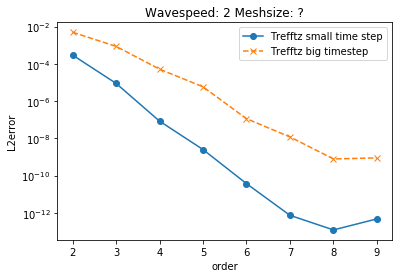

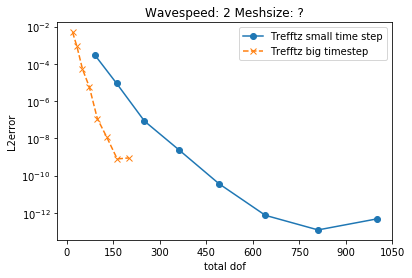

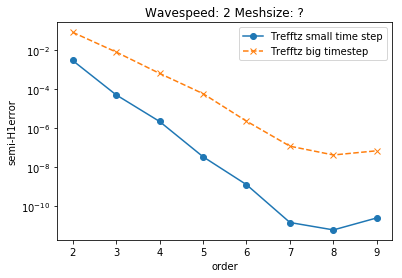

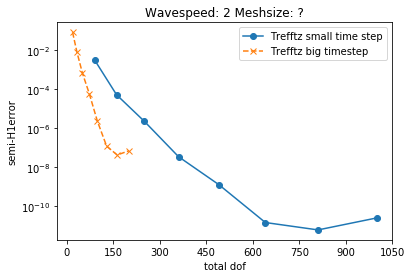

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

label = ['','order','total dof','condition', 'L2error', 'semi-H1error']
sol = np.array(solution)

for yaxis in [4,5]:
    for xaxis in [1,2]:
        fig = plt.figure()
        ax = fig.gca()
        plt.semilogy(sol[sol[:,0]==t_stepsize_small,xaxis], sol[sol[:,0]==t_stepsize_small,yaxis], '-o', label="Trefftz small time step")
        plt.semilogy(sol[sol[:,0]==t_stepsize_big,xaxis], sol[sol[:,0]==t_stepsize_big,yaxis], '--x', label="Trefftz big timestep")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title('Wavespeed: ' + str(c) + " Meshsize: " + str("?"))
        plt.legend()
        plt.ylabel(label[yaxis])
        plt.xlabel(label[xaxis])
        #plt.savefig("results/3Dstepsize_"+label[yaxis]+label[xaxis]+".png")
        plt.show()